In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

## code

In [3]:
# First, let's diagnose what might be wrong
print("Running diagnostics on the dataset...")

# Diagnostic function to identify potential issues
def diagnose_data(df):
    # Check if trip_duration exists and its statistics
    if 'trip_duration' in df.columns:
        print("\nTrip Duration Statistics:")
        print(f"Min: {df['trip_duration'].min()} seconds")
        print(f"Max: {df['trip_duration'].max()} seconds")
        print(f"Mean: {df['trip_duration'].mean():.2f} seconds")
        print(f"Median: {df['trip_duration'].median()} seconds")

        # Check for negative or zero values
        neg_duration = (df['trip_duration'] <= 0).sum()
        if neg_duration > 0:
            print(f"WARNING: Found {neg_duration} rows with zero or negative trip duration!")
    else:
        print("ERROR: 'trip_duration' column not found in dataframe!")
    # Check distance calculation # Fixed: Removed the extra indent here
    if 'distance' in df.columns:
        print("\nDistance Statistics:")
        print(f"Min: {df['distance'].min()} km")
        print(f"Max: {df['distance'].max()} km")
        print(f"Mean: {df['distance'].mean():.2f} km")
        print(f"Median: {df['distance'].median()} km")

        # Check for zero or negative distances
        zero_dist = (df['distance'] <= 0).sum()
        if zero_dist > 0:
            print(f"WARNING: Found {zero_dist} rows with zero or negative distance!")
    else:
        print("ERROR: 'distance' column not found in dataframe!")
    # Check coordinates # This line was incorrectly indented before
    coord_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
    missing_coords = [col for col in coord_cols if col not in df.columns]
    if missing_coords:
        print(f"ERROR: Missing coordinate columns: {missing_coords}")
    else:
        print("\nCoordinate Ranges:")
        for col in coord_cols:
            print(f"{col}: {df[col].min()} to {df[col].max()}")

    # Check for obvious outliers in coordinates (outside NYC)
    if all(col in df.columns for col in coord_cols):
        outside_nyc = ((df['pickup_latitude'] < 40.5) | (df['pickup_latitude'] > 41.0) |
                      (df['pickup_longitude'] < -74.2) | (df['pickup_longitude'] > -73.7) |
                      (df['dropoff_latitude'] < 40.5) | (df['dropoff_latitude'] > 41.0) |
                      (df['dropoff_longitude'] < -74.2) | (df['dropoff_longitude'] > -73.7))
        outside_count = outside_nyc.sum()
        if outside_count > 0:
            print(f"WARNING: Found {outside_count} trips with coordinates outside NYC area!")

    # Plot key relationships to check for data issues
    if all(col in df.columns for col in ['trip_duration', 'distance']):
        sample = df.sample(min(5000, len(df)))
        plt.figure(figsize=(10, 6)) # Fixed: This line was incorrectly indented before
        plt.scatter(sample['distance'], sample['trip_duration'], alpha=0.3) # Fixed: This line was incorrectly indented before
        plt.title('Trip Duration vs Distance') # Fixed: This line was incorrectly indented before
        plt.xlabel('Distance (km)') # Fixed: This line was incorrectly indented before
        plt.ylabel('Trip Duration (seconds)') # Fixed: This line was incorrectly indented before
        plt.xlim(0, sample['distance'].quantile(0.99)) # Fixed: This line was incorrectly indented before
        plt.ylim(0, sample['trip_duration'].quantile(0.99)) # Fixed: This line was incorrectly indented before
        plt.show() # Fixed: This line was incorrectly indented before

        # Calculate correlation
        corr = df['distance'].corr(df['trip_duration'])
        print(f"\nCorrelation between distance and trip_duration: {corr:.4f}")
        if corr < 0.5:
            print("WARNING: Low correlation between distance and trip_duration suggests data issues!")

Running diagnostics on the dataset...


In [4]:
# Run diagnostics on a sample of the data
sample_for_diag = df.sample(min(10000, len(df)), random_state=42)
diagnose_data(sample_for_diag)

# Based on diagnostics, let's fix potential issues

# 1. Recalculate trip_duration if needed
if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
    print("\nRecalculating trip_duration from datetime columns...")
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    df['trip_duration_recalc'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()

    # Compare with existing trip_duration if it exists
    if 'trip_duration' in df.columns:
        duration_diff = np.abs(df['trip_duration'] - df['trip_duration_recalc'])
        large_diff = (duration_diff > 60).sum()  # More than 1 minute difference
        print(f"Found {large_diff} trips with >60 second difference in duration calculation")

        # Use recalculated duration if there are large differences
        if large_diff > len(df) * 0.01:  # If more than 1% have large differences
            print("Using recalculated trip_duration due to discrepancies")
            df['trip_duration'] = df['trip_duration_recalc']
    else:
        print("Using calculated trip_duration")
        df['trip_duration'] = df['trip_duration_recalc']

    # Clean up
    df.drop('trip_duration_recalc', axis=1, inplace=True)

# 2. Recalculate distance if needed
print("\nRecalculating distance using haversine formula...")
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points on Earth."""
    R = 6371  # Earth radius in kilometers
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

df['distance_recalc'] = haversine_distance(
    df['pickup_latitude'],
    df['pickup_longitude'],
    df['dropoff_latitude'],
    df['dropoff_longitude']
)


Trip Duration Statistics:
Min: 1 seconds
Max: 86332 seconds
Mean: 912.86 seconds
Median: 664.5 seconds
ERROR: 'distance' column not found in dataframe!

Coordinate Ranges:
pickup_latitude: 40.57958984375 to 40.90084838867188
pickup_longitude: -74.19617462158203 to -73.5481185913086
dropoff_latitude: 40.32324981689453 to 41.06317138671875
dropoff_longitude: -74.32666778564453 to -73.5481185913086

Recalculating trip_duration from datetime columns...
Found 0 trips with >60 second difference in duration calculation

Recalculating distance using haversine formula...


In [5]:
# Compare with existing distance if it exists
if 'distance' in df.columns:
    distance_diff = np.abs(df['distance'] - df['distance_recalc'])
    large_diff = (distance_diff > 0.5).sum()  # More than 0.5 km difference
    print(f"Found {large_diff} trips with >0.5 km difference in distance calculation")

    # Use recalculated distance if there are large differences
    if large_diff > len(df) * 0.01:  # If more than 1% have large differences
        print("Using recalculated distance due to discrepancies")
        df['distance'] = df['distance_recalc']
else:
    print("Using calculated distance")
    df['distance'] = df['distance_recalc']

# Clean up
df.drop('distance_recalc', axis=1, inplace=True)

# 3. Aggressively remove outliers
print("\nRemoving outliers...")
before_rows = len(df)

# Remove trips with unreasonable durations
df = df[(df['trip_duration'] >= 30) & (df['trip_duration'] <= 7200)]  # Between 30 sec and 2 hours

# Remove trips with unreasonable distances
df = df[(df['distance'] > 0.1) & (df['distance'] <= 50)]  # Greater than 100m and less than 50km

# Remove trips with unreasonable speeds (km/h)
df['speed'] = df['distance'] / (df['trip_duration'] / 3600)
df = df[(df['speed'] > 1) & (df['speed'] <= 80)]  # Between 1 km/h and 80 km/h

# Remove trips outside NYC boundaries
df = df[(df['pickup_latitude'] > 40.5) & (df['pickup_latitude'] < 41.0) &
        (df['pickup_longitude'] > -74.2) & (df['pickup_longitude'] < -73.7) &
        (df['dropoff_latitude'] > 40.5) & (df['dropoff_latitude'] < 41.0) &
        (df['dropoff_longitude'] > -74.2) & (df['dropoff_longitude'] < -73.7)]

after_rows = len(df)
removed_pct = (before_rows - after_rows) / before_rows * 100
print(f"Removed {before_rows - after_rows} rows ({removed_pct:.2f}% of data) as outliers")

Using calculated distance

Removing outliers...
Removed 9071 rows (1.24% of data) as outliers


In [7]:
# 4. Generate robust time-based features
print("\nCreating time features...")
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['pickup_is_weekend'] = df['pickup_dayofweek'].isin([5, 6]).astype(int)
df['pickup_is_rush_hour'] = (((df['pickup_hour'] >= 7) & (df['pickup_hour'] <= 10)) |
                           ((df['pickup_hour'] >= 16) & (df['pickup_hour'] <= 19))).astype(int)

# 5. Generate Manhattan distance (often more relevant than haversine for taxis)
print("Creating Manhattan distance...")
df['manhattan_distance'] = np.abs(df['dropoff_longitude'] - df['pickup_longitude']) + \
                          np.abs(df['dropoff_latitude'] - df['pickup_latitude'])

# Now let's train a simple model to verify R² improvement
print("\nTraining a simple LightGBM model on fixed data...")

# Sample the data to prevent memory issues
#sample_size = min(100000, len(df))
#df_sample = df.sample(sammple_size, random_state=42)

# Use only the most predictive features
features = [
    'distance',  # Should be highly predictive now
    'manhattan_distance',
    'pickup_hour',
    'pickup_dayofweek',
    'pickup_is_weekend',
    'pickup_is_rush_hour',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude'
]


Creating time features...
Creating Manhattan distance...

Training a simple LightGBM model on fixed data...


In [8]:
# Make sure all features exist
features = [f for f in features if f in df.columns]

X = df[features]
y = df['trip_duration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LightGBM model
import lightgbm as lgb
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=50,
    max_depth=8,
    learning_rate=0.1,
    verbose=-1
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel evaluation after fixing data issues:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} seconds")


Model evaluation after fixing data issues:
R² Score: 0.7680
RMSE: 311.01 seconds


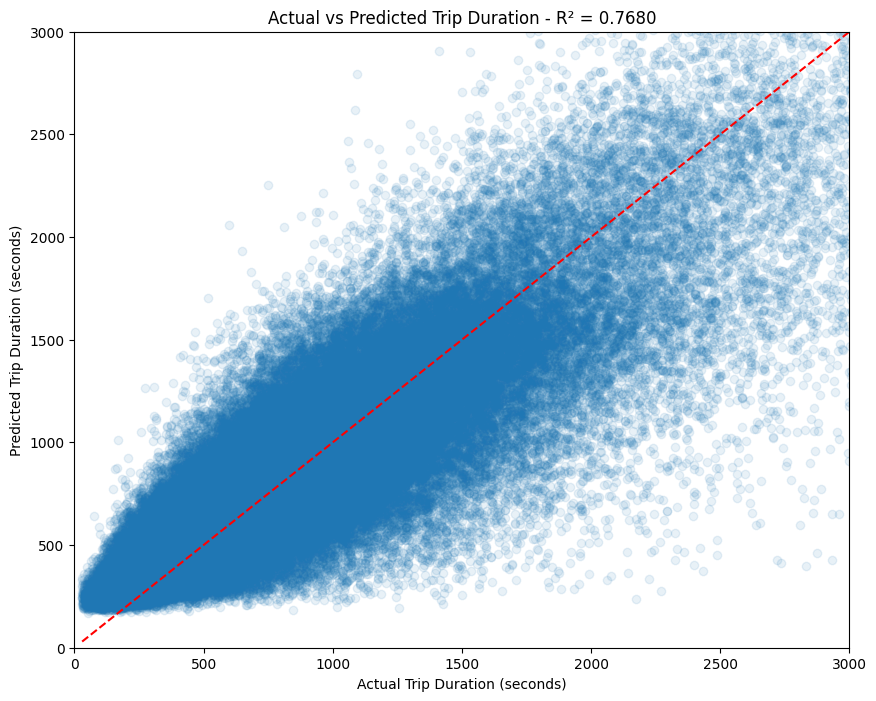

In [10]:

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Trip Duration (seconds)')
plt.ylabel('Predicted Trip Duration (seconds)')
plt.title(f'Actual vs Predicted Trip Duration - R² = {r2:.4f}')
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.show()



Feature Importance:
               Feature  Importance
2          pickup_hour         419
3     pickup_dayofweek         219
8     dropoff_latitude         212
0             distance         198
9    dropoff_longitude         170
7     pickup_longitude         154
6      pickup_latitude          96
1   manhattan_distance          17
5  pickup_is_rush_hour          12
4    pickup_is_weekend           3


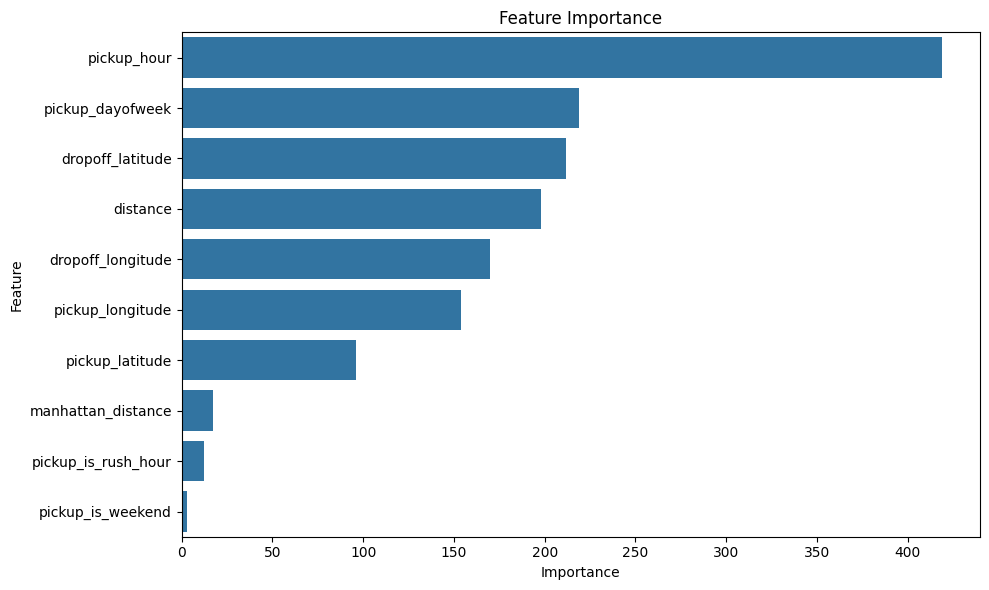

In [11]:
# Feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()